# Generating new faces with Variational Autoencoders
Dhanush Kamath | [GitHub](https://github.com/dhanushkamath) | [LinkedIn](https://www.linkedin.com/in/dhanushkamath/)

Deep generative models such as Generative Adversarial Networks (GANs) are gaining tremendous popularity, both in the industry as well as academic research. In fact, Yann LeCun, the father of the Convolutional Neural Network, described it as “the most interesting idea in the last 10 years in Machine Learning.” The idea of a computer program generating new human faces or new animals can be quite exciting. Deep generative models take a slightly different approach compared to supervised learning which we shall discuss very soon.

This quick and concise tutorial covers the basics of Deep Generative Modelling with Variational Autoencoders. I am assuming that you are fairly familiar with the concepts of Convolutional Neural Networks and representation learning. If not, I would recommend watching Andrej Karpathy's [CS231n lecture videos](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC) as they are, in my honest opinion, the best resource for learning CNNs on the internet. You can also find the lecture notes for the course [here](http://cs231n.github.io/).

This example demonstrates the process of building and training a VAE using Keras to generate new faces. We shall be using the [CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/jessicali9530/celeba-dataset) from Kaggle and [Google Colab](https://colab.research.google.com/) for training the VAE model.

## GENERATIVE MODELS

If you're beginning to explore the field of Generative Deep Learning, a Variational Autoencoder (VAE) is ideal to kick off your journey. The VAE architecture is intuitive and simple to understand. Contrary to a discriminative model such as a CNN classifier a generative model attempts to learn the underlying distribution of the data rather than classifying the data into one of many categories. A well trained CNN classifier would be highly accurate in differentiating an image of a car from that of a house. However, this does not accomplish our objective of generating images of cars and houses.

A discriminative model learns to capture useful information from the data and utilise that information to classify a new data point into one of two or more categories. From a probabilistic perspective, a discriminative model estimates the probability $p(y|x)$, where $y$ is the category or class and $x$ is the data point. It estimates the probability of a datapoint $x$ belonging to the category $y$. For example, the probability of an image being that of a car or a house. 

A generative model learns the underlying distribution of the data that explains how the data was generated. In essence, it mimics the underlying distribution and allows us to sample from it to generate new data. It can be defined as estimating the probability $p(x)$, where $x$ is the data point. It estimates the probability of observing the data point $x$ in the distribution. 



## SIMPLE AUTOENCODER

Before delving into a Variational Autoencoder, it is crucial to analyse a simple Autoencoder. 

A simple or Vanilla Autoencoder consists of two neural networks - an Encoder and a Decoder. An Encoder is responsible for converting an image into a compact lower dimensional vector (or latent vector). This latent vector is a compressed representation of the image. The Encoder, therefore maps an input from the higher dimensional input space to the lower dimensional latent space. This is similar to a CNN classifier. In a CNN classifier, this latent vector would be subsequently fed into a softmax layer to compute individual class probabilities. However in an Autoencoder, these outputs are fed into the Decoder. The Decoder is a different neural network that tries to reconstruct the image, thereby mapping from the lower dimenstional latent space to the higher dimensional output space. The Encoder and Decoder perform mappings that are exactly opposite to each other, as shown in the image <i>img-1</i>. 


<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"> 
<br><i>img-1</i>
<br><i>Source : en.wikipedia.org/wiki/Autoencoder</i>

<br><br>
Consider the following analogy to understand this better. Imagine you're playing a game with your friend over the phone. The rules of the game are simple. You are presented with a number of different cylinders. Your task is to describe the cylinders to your friend who will then attempt to recreate them out of modelling clay. You are forbidden from sending pictures. How will you convey this information? 

Since any cylinder can be constructed with two parameters - its height and diameter, the most efficient strategy would be to estimate these two measures and convey them to your friend. Your friend, upon receiving this information can then reconstruct the cylinder. In this example, it is quite evident that you are performing the function of an Encoder by condensing visual information into two quantities. Your friend on the contrary, is performing the function of a Decoder by utilising this condensed information to recreate the cylinder.




## HOUSEKEEPING

### Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
from PIL import Image, ImageOps


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

Since the dataset is quite large, we shall create an <i>ImageDataGenerator</i> object and employ its member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. The ImageDataGenerator can also be used to dynamically apply various transformations for image augmentation which is particularly useful in the case of small datasets.

I highly encourage you to refer to the [documentation](https://keras.io/preprocessing/image/#flow_from_directory) for understanding the various parameters of the dataflow function. 

### Data

In [2]:
X = np.load('datasets/X_train_128.npy')
X_test = np.load('datasets/X_test_128.npy')
X_color = np.load('datasets/train_128_color_filt.npy')
X_test_color = np.load('datasets/test_128_color_filt.npy')


In [3]:
INPUT_DIM = (128,96,3) # Image dimension
Z_DIM = 75 # Dimension of the latent vector (z)

### MODEL ARCHITECTURE


#### Building the Encoder


In [4]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
        if use_batch_norm:
            x = BatchNormalization()(x)

        x = LeakyReLU()(x)

        if use_dropout:
            x = Dropout(rate=0.25)(x)

    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 

    x = Flatten()(x)

    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    

    return encoder_input, mean_mu, log_var, shape_before_flattening, Model(encoder_input, [mean_mu, log_var])

In [5]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)

        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [6]:
vae_encoder_input, mean_mu, log_var, vae_shape_before_flattening, vae_encoder = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 96, 3)] 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 48, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 48, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 24, 64)   18496       leaky_re_lu[0][0]                
______________________________________________________________________________________________

#### Building the Decoder
Since the Decoder remains the same, the Decoder architecture of the Simple Autoencoder is reused.

In [7]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,INPUT_DIM[-1]],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 75)]              0         
_________________________________________________________________
dense (Dense)                (None, 3072)              233472    
_________________________________________________________________
reshape (Reshape)            (None, 8, 6, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 12, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 12, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 24, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 24, 64)        0   

### COMPILATION AND TRAINING


The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [48]:
# Defining a function for sampling
def sampling(args):
    mean_mu, log_var = args
#     epsilon = K.random_normal(shape=tf.shape(mean_mu), mean=0., stddev=1.) 
    epsilon = 0
    return mean_mu + K.exp(log_var/2)*epsilon

# Using a Keras Lambda Layer to include the sampling function as a layer 
# in the model
#     encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])
z = Lambda(sampling, name='encoder_output')([mean_mu, log_var])
out = vae_decoder(z)

In [9]:
LEARNING_RATE = 0.0005 * 2 * 2
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [10]:
def r_loss2(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(mean_mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = (1))

def total_loss(y_true, y_pred, mean_mu, log_var):
    return LOSS_FACTOR*r_loss2(y_true, y_pred) + kl_loss(mean_mu, log_var)

In [11]:
adam_optimizer = Adam(lr = LEARNING_RATE)

checkpoint_vae = ModelCheckpoint(os.path.join('weights', 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [49]:
vae_model = Model(vae_encoder_input, out)
vae_model.load_weights('weights/VAE/weights.h5')

In [ ]:
samples = len(X_color)
batch_size = 128


vae_model = Model(vae_encoder_input, out)
vae_model.add_loss(total_loss(vae_encoder_input, out, mean_mu, log_var))
vae_model.compile(optimizer=adam_optimizer, loss=None)
# vae_model.summary()

vae_model.fit(X_color[:samples], X_color[:samples],
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=samples / batch_size,
                                 callbacks=[checkpoint_vae])

### RECONSTRUCTION.
The reconstruction process is the same as that of the Simple Autoencoder.

In [14]:
import matplotlib.pyplot as plt
def plot_compare_vae(images=None):
  
    if images is None:
        example_batch = next(data_flow)
        example_batch = example_batch[0]
        images = example_batch[:10]

    n_to_show = images.shape[0]
    reconst_images = vae_model.predict(images)

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img, cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img, cmap='gray')  

In [71]:
def test_img(path):
    img = Image.open(path).resize((96, 128))
    arr = np.array(img).reshape((1,128,96,3)) / 255

    pred = vae_model.predict(arr) # 75filt
    img_arr = (pred.reshape((128,96, 3)) * 255).astype(np.uint8)
    display(img)
    display(Image.fromarray(img_arr))

In [131]:
img = Image.open('chris.jpg')
Image.fromarray(np.array(img)[:-175, 50:-50, :]).resize((96, 128)).save('chris2.jpg')

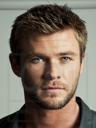

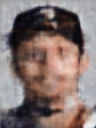

In [132]:
test_img('chris2.jpg')

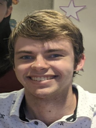

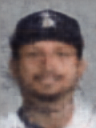

In [82]:
test_img('nick.jpg')

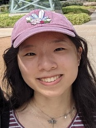

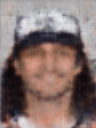

In [70]:
test_img('annabel3.jpg')

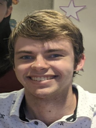

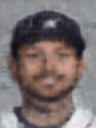

In [210]:
test_img('nick.jpg')

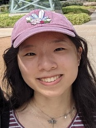

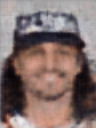

In [211]:
test_img('annabel3.jpg')

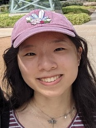

In [168]:
annabel = Image.open('annabel3.jpg').resize((96, 128))
arr = np.array(annabel).reshape((1,128,96,3)) / 255
annabel

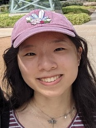

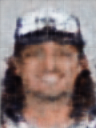

In [191]:
pred = vae_model.predict(arr) # 50filt
img_arr = (pred.reshape((128,96, 3)) * 255).astype(np.uint8)
display(annabel)
Image.fromarray(img_arr)

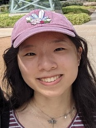

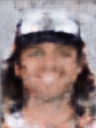

In [169]:
predbg = vae_model.predict(arr) # 50bgfilt
img_arrbg = (predbg.reshape((128,96, 3)) * 255).astype(np.uint8)
display(annabel)
Image.fromarray(img_arrbg)

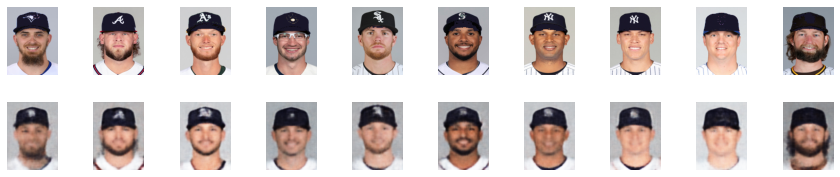

In [212]:
plot_compare_vae(X_color[:10]) 

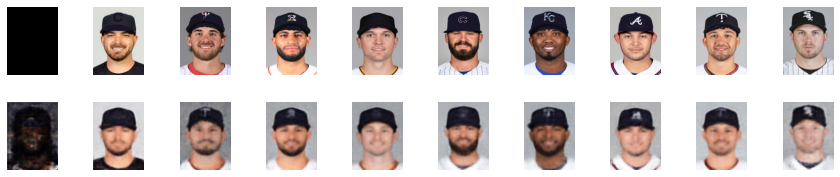

In [214]:
plot_compare_vae(X_test_color[:10]) 

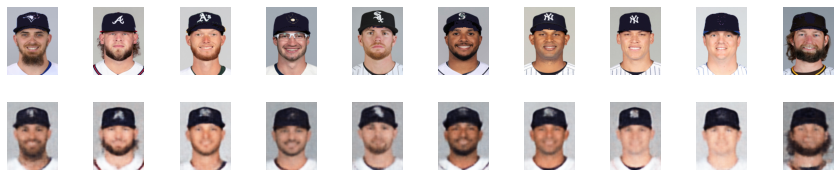

In [157]:
plot_compare_vae(X_color[:10]) # 75

### Generating new faces from random vectors sampled from a standard normal distribution. 

In [68]:
def vae_generate_images(n_to_show=10):
    reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))
    return reconst_images
    
def show_imgs(imgs):
    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(len(imgs)):
        img = imgs[i].squeeze()
        sub = fig.add_subplot(2, len(imgs), i+1)
        sub.axis('off')        
        sub.imshow(img, cmap='gray')


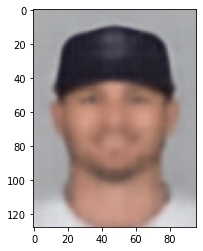

In [218]:
plt.imshow(vae_decoder.predict([[0] * 75])[0])

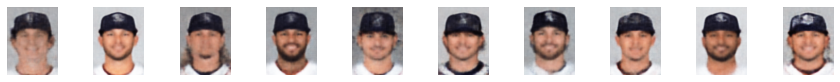

In [216]:
fakes4 = vae_generate_images(n_to_show=10)
show_imgs(fakes4)

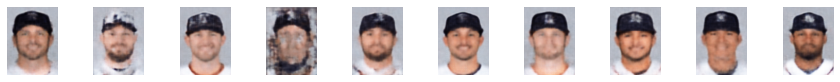

In [215]:
fakes3 = vae_generate_images(n_to_show=10)
show_imgs(fakes3)


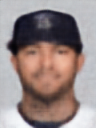

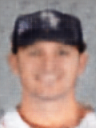

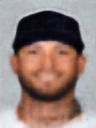

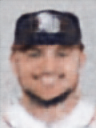

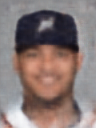

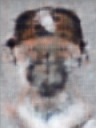

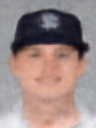

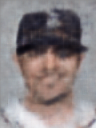

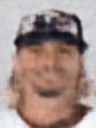

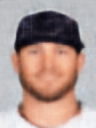

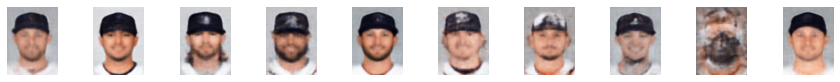

In [140]:
# 50, filt

# fakes = vae_generate_images(n_to_show=10)
show_imgs(fakes)
nearest = ((X_color - fakes[0]) ** 2).mean(axis=(1,2,3)).argmin()
for img in fakes2:
    display(Image.fromarray((img.reshape((128,96,3)) * 255).astype(np.uint8)))

The VAE is evidently capable enough of producing new faces from vectors samped from a standard normal distribution. The fact that a neural network is capable of generating new faces from random noise shows how powerful it is in performing extremely complex mappings!

As it is impossible to visualize a 200 dimensional vector, some of the elements of the latent vector are individually visualized to see if they are close to a standard normal distribution.

In [72]:
from scipy.stats import norm

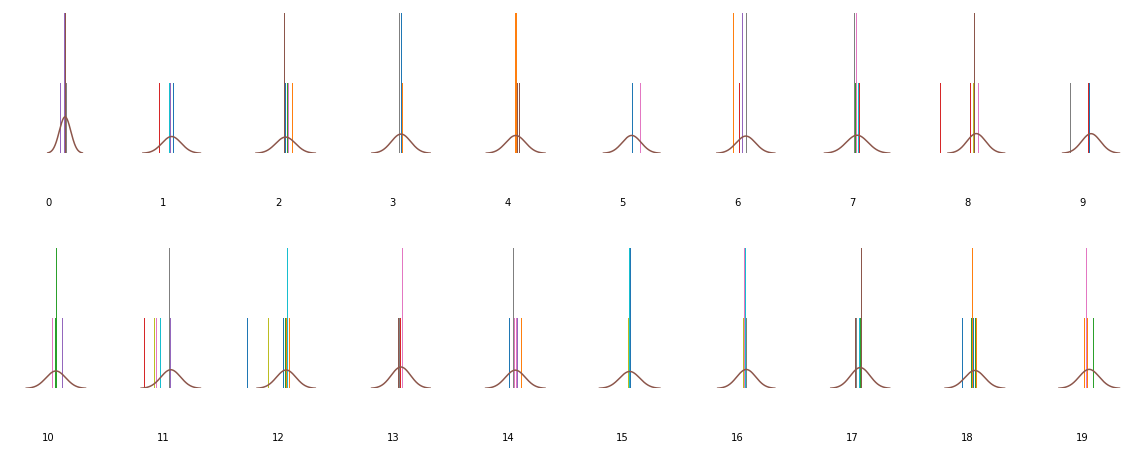

In [75]:
z_test = np.array(vae_encoder.predict(X_color[:50]))

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

It is observed that the first 50 elements of the Z dimensional vector are very similar to a standard normal distribution. The addition of the KL divergence term is therefore, justified. 